In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from libpysal.weights import fuzzy_contiguity
import json
import dask
from dask import delayed, dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.graph_manipulation import bind
import bokeh
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
import glob
import dask.bag as db
from itertools import chain
import json
import warnings
import matplotlib.pyplot as plt
import logging
import dask.config

In [ ]:
with open('./out/singapore/clustertess.json', 'r') as f:
    includes_dict = json.load(f)

In [ ]:
chunks = gpd.read_parquet('./out/singapore/clusters.pq')

In [ ]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

In [ ]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [ ]:
import dask
dask.config.set({'logging.distributed': 'error'})

In [25]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34773/status,
Dashboard: http://127.0.0.1:34773/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45993,Workers: 8
Dashboard: http://127.0.0.1:34773/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:45981,Total threads: 2
Dashboard: http://127.0.0.1:43291/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:45179,


In [26]:
def duplicates(tessellation):

    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        print("combined_chunk no problems")
        return 0

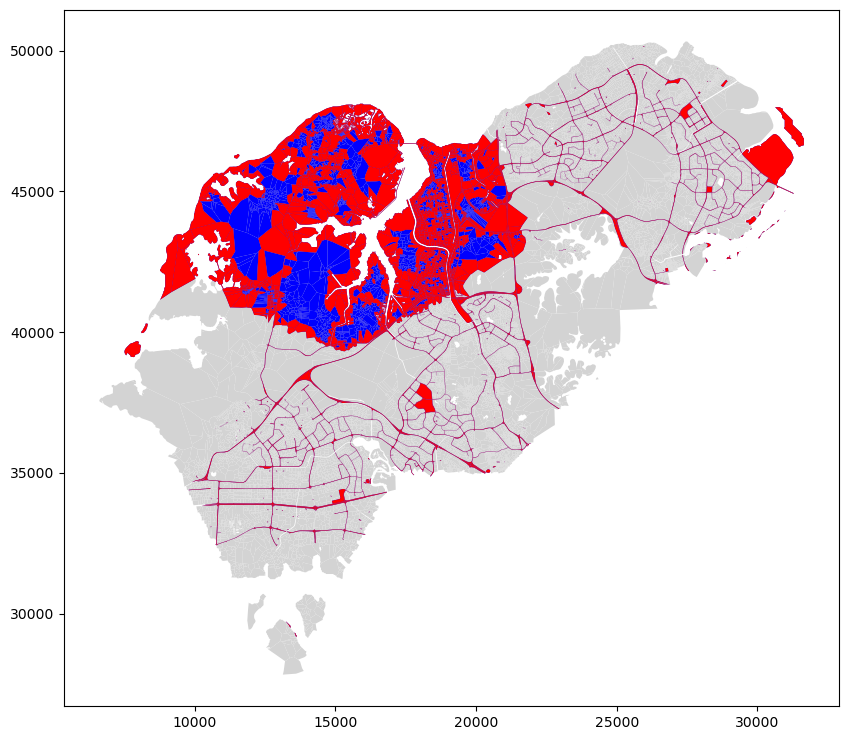

starting expand_one_order, chunk 0 order 3


NameError: name 'combined_chunk' is not defined

In [27]:
queen_out = {}

@delayed
def neigh_look(cell_id, main_chunk_ids, search_cells): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
        cell_poly = search_cells.loc[search_cells['uID'] == cell_id]
        neighbours = search_cells[~search_cells.geometry.disjoint(cell_poly)]
        return neighbours.uID.tolist()

def expand_one_order(n1, main_chunk_ids, added_cells_ids, order, combined_chunks):
    
    red_gdf = combined_chunks[combined_chunks['uID'].isin(added_cells_ids)]
    
    blue_gdf = combined_chunks[combined_chunks['uID'].isin(main_chunk_ids)]
    
    # plot the GeoDataFrames on the same plot
    fig, ax = plt.subplots(figsize=(10, 10))
    combined_chunks.plot(ax=ax, color='lightgray')
    blue_gdf.plot(ax=ax, color='blue')
    red_gdf.plot(ax=ax, color='red')
    plt.show()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
    
        print("starting expand_one_order, chunk " + str(n1) + " order " + str(order), flush=True)
                
        if order == 0:
            return main_chunk_ids

        results = db.from_sequence(main_chunk_ids)
        
        chunk_size = 32
        added_cells_ids_chunks = [added_cells_ids[i:i+chunk_size] for i in range(0, len(added_cells_ids), chunk_size)]
        
        len_sublist = len(added_cells_ids_chunks)
        
        search_cells = combined_chunk[~combined_chunk['uID'].isin(added_cells_ids)]
        
        for i, sublist in enumerate(added_cells_ids_chunks):

            delay_objs =[]
            new_results = []
                
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                delay_objs = [neigh_look(cell_id, main_chunk_ids, search_cells) for cell_id in sublist]
                new_results = dask.compute(delay_objs)
                new_results_bag = db.from_sequence(chain(*new_results[0]))
                results = db.concat([results, new_results_bag]).distinct()
                
                        
            print("compute done this wave", flush=True)
            print("chunk " + str(n1) + " , order " + str(order) +" , sublist " + str(i) + " of " + str(len_sublist), flush=True)
                
        expanded_cells = list(results.compute())

        neighbouring_cells = [cell for cell in added_cells_ids if cell not in main_chunk_ids]
        print("cells added this wave", flush=True)
    
    return expand_one_order(n1, expanded_cells, neighbouring_cells, order-1, combined_chunks)
    
def process_chunk(n1, order, neighbours, chunk):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
            
        main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
        combined_chunks = main_chunk

        main_chunk_ids = list(main_chunk['uID'])
        results = []

        for n2 in neighbours:
            neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
            combined_chunks = combined_chunks.append(neigh_chunk)

        combined_chunks = combined_chunks.reindex()
        
        chunk_boundary = []
        
        buffer = gpd.GeoDataFrame(geometry = [chunk.boundary[n1].buffer(5)], crs=main_chunk.crs)
        
        # find the rows in main_chunk that intersect the buffered polygon
        intersecting_rows = gpd.sjoin(main_chunk, buffer, how='inner', op='intersects')
        
#         intersecting_rows.plot(figsize=(5, 5))
#         plt.show()
        
        out = expand_one_order(n1, main_chunk_ids, intersecting_rows["uID"].tolist(), order, combined_chunks)
        
        return out

# for n1 in tqdm(range(10), total=10):
#     queen_out[n1] = process_chunk(n1)

file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

# combined_chunks=[]
# delayed_tasks = []
# for n1 in range(num_files):
#     delayed_task = process_chunk(n1, w, combined_chunks)
#     delayed_tasks.append(delayed_task)

#     results = delayed_tasks

queen_out = [process_chunk(n1, 3, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]


for n1 in tqdm(range(num_files)):
    queen_out[n1].to_parquet(f"./out/singapore/queen_{int(n1)}.pq")

In [ ]:
daskCluster.close()
client.shutdown()


In [ ]:
queen_out.to_parquet("./out/singapore/queen_areas.pq")